In [1]:
%pip install openai
import os

import openai
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import PIL.Image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 146 kB 12.6 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55880 sha256=bd98e5f1cb1ce81b72264e2be82842ccff91d344b79110f205c52d4d2aae6a13
  Stored in directory: /root/.cache/pip/wheels/4b/92/33/6f57c7aae0b16875267999a50570e81f15eecec577ebe05a2e
Successfully built openai


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
%ls /content/drive/MyDrive/cs1470_final

api_key.txt             pic0.jpg  pic2.jpg  style.jpg
image_generating.ipynb  pic1.jpg  pic3.jpg


In [5]:
import requests

In [4]:
f = open("/content/drive/MyDrive/cs1470_final/api_key.txt", "r")
openai.api_key = f.read()


In [37]:
prompts = ["a dragon standing in front of a tall mountain", "elves meeting beside a river", "dwarves hidding gold in their mountain"]

In [7]:
path = '/content/drive/MyDrive/cs1470_final/pic' + str(1) + '.jpg'

In [38]:
count = 0
for prompt in prompts:
    response = openai.Image.create(
    prompt=prompt,
    n=1,
    size="1024x1024"
  )
    
    image_url = response['data'][0]['url']
    count += 1
    path = '/content/drive/MyDrive/cs1470_final/pic' + str(count) + '.jpg'
    with open(path, 'wb') as handle:
      response = requests.get(image_url, stream=True)

      if not response.ok:
          print(response)

      for block in response.iter_content(1024):
          if not block:
              break

          handle.write(block)

In [39]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [44]:
style_image = load_img('/content/drive/MyDrive/cs1470_final/style.jpg')

In [41]:
img_count = len(prompts)
base_path = '/content/drive/MyDrive/cs1470_final/pic'
generate_images = []

for i in range(img_count):
  img_path = base_path + str(i+1) + '.jpg'
  generate_image = load_img(img_path)
  generate_images.append(generate_image)

In [42]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)

    if title:
        plt.title(title)

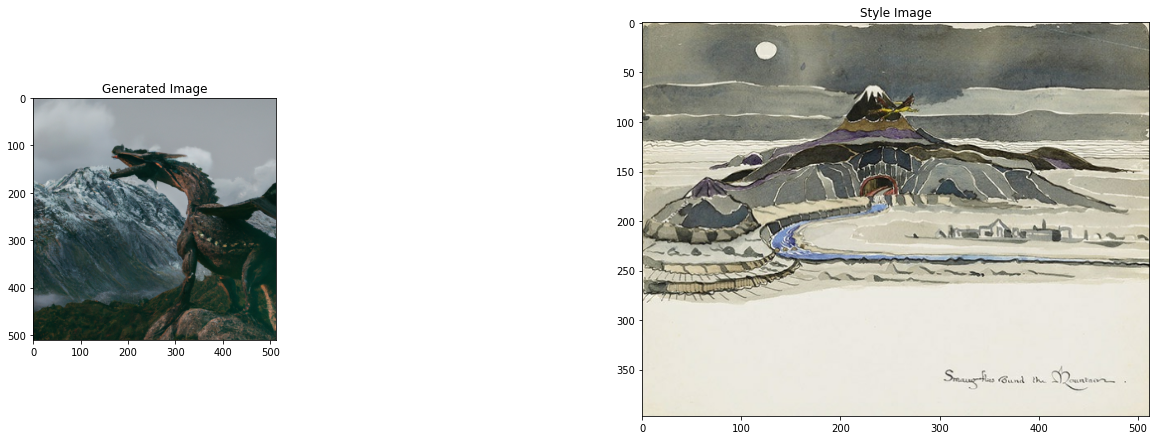

In [45]:
#Let's look at the first image
plt.figure(figsize=(20,20))

plt.subplot(1, img_count+1, 1)
imshow(generate_images[0], 'Generated Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [47]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [48]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [49]:
class StyleModel(tf.keras.models.Model):
    def __init__(self):
        super(StyleModel, self).__init__()
        self.style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

        self.vgg = vgg_layers(self.style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs = [gram_matrix(output)
                         for output in outputs]

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return style_dict

In [50]:
class ContentModel(tf.keras.models.Model):
    def __init__(self):
        super(ContentModel, self).__init__()
        self.total_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1',
                'block5_conv2']
        self.vgg = vgg_layers(self.total_layers)
        self.content_layers = ['block5_conv2'] 
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        content_outputs = outputs[:-len(self.content_layers)]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        return content_dict

In [51]:
style_extractor = StyleModel()
content_extractor = ContentModel()


In [52]:
style_targets = style_extractor(style_image)
content_targets = content_extractor(generate_image)

In [53]:
def style_loss(style_outputs):
  style_loss = 0
  for name in style_outputs.keys():
    style_loss += tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)])
  
  return style_loss

In [54]:
def content_loss(content_outputs):
  content_loss = 0
  for name in content_outputs.keys():
    content_loss += tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)])
  
  return content_loss

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, epsilon=1e-1)

In [56]:
def train_step(image):
    with tf.GradientTape() as tape:
        style_outputs = style_extractor(image)
        content_outputs = content_extractor(image)

        loss = style_loss(style_outputs) + content_loss(content_outputs)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])

In [60]:
image = tf.Variable(generate_images[0])

In [34]:
tf.config.run_functions_eagerly(True)

In [57]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


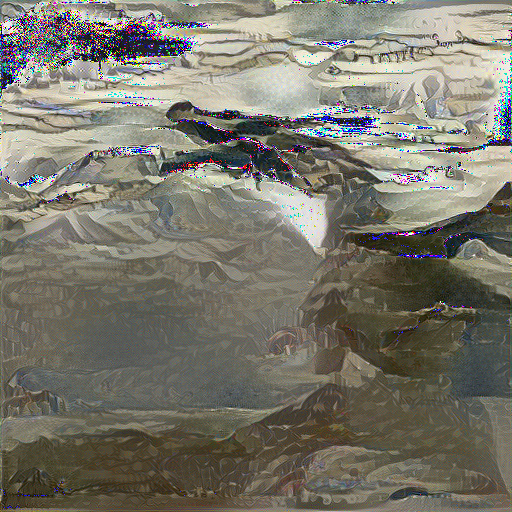

Train step: 3000
Total time: 616.5


In [61]:
import time
import IPython.display as display

start = time.time()

epochs = 30
steps = 100

step = 0
for n in range(epochs):
    for m in range(steps):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
